In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, h5py
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

os.environ["OMP_NUM_THREADS"] = str(len(os.sched_getaffinity(0)))
import healpy as hp

from scipy.signal import savgol_filter
from tqdm import tqdm

from deepsphere.healpy_layers import HealpySmoothing
from msfm.utils import tfrecords, files, parameters, scales, power_spectra, cross_statistics
from msfm.fiducial_pipeline import FiducialPipeline
from msfm.utils.input_output import read_yaml

from msi.utils import preprocessing, plotting, input_output

tf.config.experimental.set_memory_growth(tf.config.list_physical_devices(device_type="GPU")[0], True)

24-05-21 06:43:01   imports.py INF   Setting up healpy to run on 32 CPUs 
24-05-21 06:43:01   imports.py INF   Setting up healpy to run on 32 CPUs 
24-05-21 06:43:03   imports.py INF   Setting up healpy to run on 32 CPUs 


In [3]:
conf = "/global/homes/a/athomsen/multiprobe-simulation-forward-model/configs/v8/linear_bias.yaml"
conf = files.load_config(conf)

n_side = 512
n_pix = hp.nside2npix(n_side)
data_vec_pix, _, _, _ = files.load_pixel_file(conf)

n_z = 8
l_min_global = 30
l_max_global = 3 * n_side - 1

24-05-21 06:43:07     files.py INF   Loaded the pixel file /global/u2/a/athomsen/multiprobe-simulation-forward-model/data/DESY3_pixels_v11_512.h5 


# build smoothing layer

In [17]:
dlss_conf = "/global/u2/a/athomsen/y3-deep-lss/configs/v8/combined/linear_bias/dlss_config.yaml"
dlss_conf = read_yaml(dlss_conf)

# dlss_conf = {
#     "scale_cuts" : {
#           "n_sigma_support": 3,
#           "arcmin": True,
#           "lensing": {
#             # 6 Mpc/h transverse comoving scale -> arcmin
#             "theta_fwhm": [22.1, 15.1, 11.2, 9.4]
#           },
#         "clustering" : {
#             # 16 Mpc/h transverse comoving scale -> arcmin
#             "theta_fwhm": [65.1, 44.5, 34.1, 28.5]
#         },
#     }
# }

            
mask_dict = files.get_tomo_dv_masks(conf)
    
mask = tf.concat([mask_dict["metacal"], mask_dict["maglim"]], axis=1)
mask = mask.numpy()

# theta_fwhms = dlss_conf["scale_cuts"]["lensing"]["theta_fwhm"] + dlss_conf["scale_cuts"]["clustering"]["theta_fwhm"]
theta_fwhms = [22.1, 15.1, 11.2, 9.4] + [65.1, 44.5, 34.1, 28.5]

# l_maxs = [785, 1150, 1519, 1519, 265, 389, 508, 608]
l_maxs = list(scales.angle_to_ell(np.array(fwhm), arcmin=True).astype(int))

smoothing_kwargs = {
    "nside": n_side,
    "indices": data_vec_pix,
    "nest": True,
    "mask": mask,
    "fwhm": theta_fwhms,
    "arcmin": True,
    # "n_sigma_support": dlss_conf["scale_cuts"]["n_sigma_support"],
    "n_sigma_support": 5,
    # naive
    # "white_noise_sigma": [0.51520719, 0.35428238, 0.27699105, 0.26566648, 1.62299023, 0.81909851, 0.64732432, 0.73886103],
    # 10%
    # "white_noise_sigma": [0.39659172, 0.27256747, 0.21457003, 0.21277644, 1.09389987, 0.58061397, 0.46553319, 0.51377827],
    # 1%
    # "white_noise_sigma": [0.12516133, 0.08745182, 0.05437602, 0.09995155, 0.26904975, 0.14492357, 0.11769442, 0.12976879],
    # 1% * 10
    "white_noise_sigma": [1.2516133, 0.8745182, 0.5437602, 0.9995155, 2.6904975, 1.4492357, 1.1769442, 1.2976879],
    # 1% without normalization
    # "white_noise_sigma": [0.00107639, 0.00119809, 0.00136985, 0.00326847, 0.26904975, 0.14492357, 0.11769442, 0.12976879],
    "data_path": ".",
}
noisy_smoothing_layer = tf.function(HealpySmoothing(**smoothing_kwargs))

smoothing_kwargs["white_noise_sigma"] = None
smoothing_layer = tf.function(HealpySmoothing(**smoothing_kwargs))

24-05-21 07:07:35     files.py INF   Loaded the pixel file /global/u2/a/athomsen/multiprobe-simulation-forward-model/data/DESY3_pixels_v11_512.h5 
Using the per channel smoothing repetitions [ 6  3  2  1 48 23 14 10]
Using the per channel smoothing scales sigma = [ 9.78  6.91  5.65  3.99 27.66 19.14 14.94 12.62] arcmin, fwhm = [23.03 16.28 13.29  9.4  65.13 45.08 35.17 29.73] arcmin
Successfully loaded sparse kernel indices and values from .
Successfully created the sparse kernel tensor
Adding white noise with sigma ListWrapper([1.2516133, 0.8745182, 0.5437602, 0.9995155, 2.6904975, 1.4492357, 1.1769442, 1.2976879]) to the smoothed map
Using the per channel smoothing repetitions [ 6  3  2  1 48 23 14 10]
Using the per channel smoothing scales sigma = [ 9.78  6.91  5.65  3.99 27.66 19.14 14.94 12.62] arcmin, fwhm = [23.03 16.28 13.29  9.4  65.13 45.08 35.17 29.73] arcmin
Successfully loaded sparse kernel indices and values from .
Successfully created the sparse kernel tensor


# load the maps

In [18]:
fidu_pipe = FiducialPipeline(
    conf=conf,
    params=[],
    with_lensing=True,
    with_clustering=True,
    with_padding=True,
    # apply_norm=False,
    apply_norm=True,
    shape_noise_scale=1.0,
    poisson_noise_scale=1.0,
)

n_side = conf["analysis"]["n_side"]
n_pix = hp.nside2npix(n_side)
data_vec_pix = fidu_pipe.data_vec_pix
n_z = fidu_pipe.n_z_metacal + fidu_pipe.n_z_maglim
l_max_global = 3 * n_side - 1

24-05-21 07:07:56     files.py INF   Loaded the pixel file /global/u2/a/athomsen/multiprobe-simulation-forward-model/data/DESY3_pixels_v11_512.h5 
24-05-21 07:07:56     files.py INF   Loaded the pixel file /global/u2/a/athomsen/multiprobe-simulation-forward-model/data/DESY3_pixels_v11_512.h5 


In [19]:
fidu_dset = fidu_pipe.get_dset(
    tfr_pattern="/pscratch/sd/a/athomsen/DESY3/v8/linear_bias_no_smoothing/tfrecords/fiducial/DESy3_fiducial_dmb_????.tfrecord",
    local_batch_size=1,
    noise_indices=10,
    n_readers=1,
    examples_shuffle_buffer=None,
    n_prefetch=2,
    is_eval=True,
)

for dv, index in fidu_dset.take(1):
    dv_smooth = smoothing_layer(dv)
    dv_noisy = noisy_smoothing_layer(dv)
    
print(dv.shape)
print(dv_smooth.shape)
print(dv_noisy.shape)

24-05-21 07:07:57 fiducial_pip WAR   Evaluation mode is activated: the random seed is fixed, the shuffle arguments ignored, and the dataset is not repeated 
24-05-21 07:07:57 fiducial_pip INF   n_workers is not set, using tf.data.AUTOTUNE. This might produce unexpected RAM usage. 
24-05-21 07:07:57 fiducial_pip INF   drop_remainder is not set, using drop_remainder = False 
24-05-21 07:07:57 fiducial_pip INF   Including noise_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
24-05-21 07:07:57 fiducial_pip INF   Interleaving with n_readers = 1 
24-05-21 07:07:57 fiducial_pip INF   Batching into 1 elements locally with drop_remainder = False 
24-05-21 07:07:57 fiducial_pip WAR   Tracing _augmentations 
24-05-21 07:07:57 fiducial_pip INF   Running on the data_vectors.keys() = dict_keys(['kg_fiducial', 'dg_fiducial', 'i_example', 'sn', 'pn', 'i_noise']) 
24-05-21 07:07:57 fiducial_pip WAR   Tracing _lensing_augmentations 
24-05-21 07:07:57 fiducial_pip WAR   Tracing _clustering_augmentations 
24-05

# comparison of the Cls

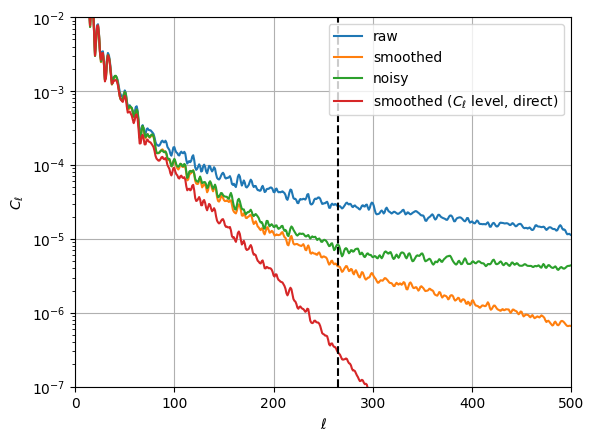

In [32]:
i_bin = 4

raw_map = np.zeros(n_pix)
raw_map[data_vec_pix] = dv[0,:,i_bin]
raw_map = hp.reorder(raw_map, n2r=True)
raw_cls = hp.anafast(raw_map)

smoothed_map = np.zeros(n_pix)
smoothed_map[data_vec_pix] = dv_smooth[0,:,i_bin]
smoothed_map = hp.reorder(smoothed_map, n2r=True)
smoothed_cls = hp.anafast(smoothed_map)

noisy_map = np.zeros(n_pix)
noisy_map[data_vec_pix] = dv_noisy[0,:,i_bin]
noisy_map = hp.reorder(noisy_map, n2r=True)
noisy_cls = hp.anafast(noisy_map)

# smoothed on cl level
low_pass_fac_cls = scales.gaussian_low_pass_factor_alm(np.arange(3*n_side), theta_fwhm=theta_fwhms[i_bin])**2
noisy_cls_direct = low_pass_fac_cls * raw_cls

noisy_cls_direct_2 = scales.cls_to_smoothed_cls(raw_cls, theta_fwhm=theta_fwhms[i_bin])

fig, ax = plt.subplots()

ax.plot(raw_cls, label="raw")
ax.plot(smoothed_cls, label="smoothed")
ax.plot(noisy_cls, label="noisy")

# ax.plot(noisy_cls_direct, label=r"noisy ($C_\ell$ level, $a_{\ell m}$ fac)")
ax.plot(noisy_cls_direct_2, label=r"smoothed ($C_\ell$ level, direct)")

ax.axvline(l_maxs[i_bin], color="k", linestyle="--")

ax.legend()
ax.set(
    xlabel=r"$\ell$", 
    ylabel=r"$C_\ell$", 
    xscale="linear", 
    yscale="log", 
    xlim=(0, 500), 
    ylim=(1e-7, 1e-2),
)
ax.grid(True)